In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
pd.options.display.max_columns = None
from pandas_ply import install_ply, X, sym_call
install_ply(pd)
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

def print_df(df):
    display(df)
    return df

from pathlib import Path
FIG_OUT_DIR = Path('Results')

In [2]:
# Debugger: After seeing an exception, uncomment and run the following
# import pdb; pdb.pm()

# Prepare results

In [3]:
## Load config from Hydra
# https://hydra.cc/docs/next/experimental/compose_api
from hydra.experimental import compose, initialize
from omegaconf import OmegaConf

if 'hydra_initialized' not in locals():
    initialize(config_dir="config")
    hydra_initialized = True
cfg = compose("config.yaml", overrides=[])
print(cfg)

run_switch = dict(
    sachs=True,
    gss = True,
    auto_mpg = True,
    red_wine = True,
    white_wine = True,
    boston_housing = True,
)

{'debug': False, 'recording': {'experiment_name': 'first', 'table_name': 'test', 'recording_set': 1, 'shared_pickle_dir': 'pickle/dev', 'save_model_path': 'outputs/saved_models', 'sacred_artifact_dir': 'outputs/sacred_artifact', 'data_cache_base_path': 'pickle/data'}, 'parallelization': {'data_run_id': '1'}, 'data': {'name': 'gss', 'module': 'gss', 'train_size': 0.3, 'data_path': 'data/gss/testdata.csv', 'graph': {'path': 'None', 'loader': 'load_graph'}, 'preprocess': [{'normalize': True}]}, 'method': {'name': 'proposed', 'fit_to_aug_only': False, 'augmenter_config_name': 'FullAugment', 'augmenter_config': {'normalize_threshold_by_data_size': True, 'weight_threshold': 0.001, 'weight_threshold_type': 'total', 'weight_kernel_cfg': {'type': 'vanilla_kernel', 'const_bandwidth': False, 'bandwidth_temperature': 0.001}}, 'aug_coeff': [0.5], 'predictor': {'n_estimators': [10, 50, 250, 1250], 'reg_lambda': [1, 10, 100, 1000]}}, 'database': {'mongo_user': 'me', 'mongo_pass': 'pass', 'mongo_host'

In [4]:
## Get records
from support.database.records_aggregator import MongoAggregator
from support.database.mongo import get_table

remote = True
remote_port = 27015
use_dumped_records = True

if use_dumped_records:
    def get_records_from_dump(table_name=None):
        import bson
        with open(Path('Records/mongodump') / f'20210105121154_mongodump_{table_name}/causal-data-augmentation/{table_name}.bson', 'rb') as f:
            data = pd.DataFrame(bson.decode_all(f.read()))
        return data
    get_records = get_records_from_dump
else:
    def get_records_from_mongo(table_name=None):
        all_records = MongoAggregator(
            get_table(cfg.recording.table_name if table_name is None else table_name, cfg.database.mongo_host,
                      cfg.database.mongo_port if not remote else remote_port, cfg.database.mongo_user,
                      cfg.database.mongo_pass, cfg.database.mongo_dbname),
            query={}).get_results_pd(index=None)
        return all_records
    get_records = get_records_from_mongo

In [5]:
all_records = {}
for data_name, run in run_switch.items():
    if not run:
        continue
    all_records.update({data_name: get_records(f'main_{data_name}')})

In [6]:
from support.pandas_support import conditional_where, conditional_mutate

PROP = (X.method == 'proposed')

records = {}
for data_name, run in run_switch.items():
    if not run:
        continue
    _records = all_records[data_name].reset_index().copy()

    namer = lambda x: f"{x['method']}"
    _records = conditional_mutate(_records, PROP, lambda _rec: _rec.ply_select('*', method=_rec.apply(namer, axis=1)))

    records.update({data_name: _records})

# sachs

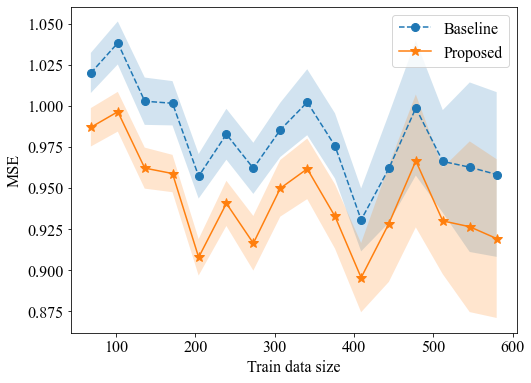

# gss

<Figure size 432x288 with 0 Axes>

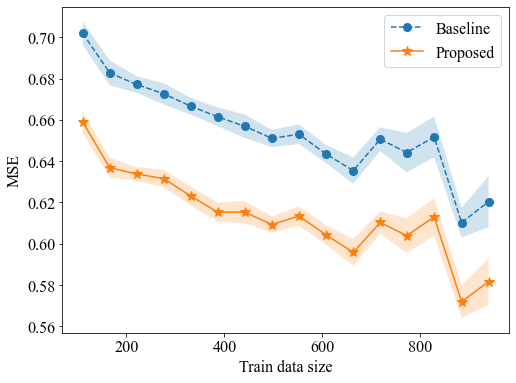

# auto_mpg

<Figure size 432x288 with 0 Axes>

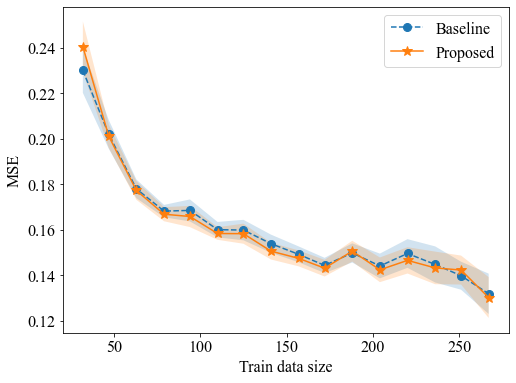

# red_wine

<Figure size 432x288 with 0 Axes>

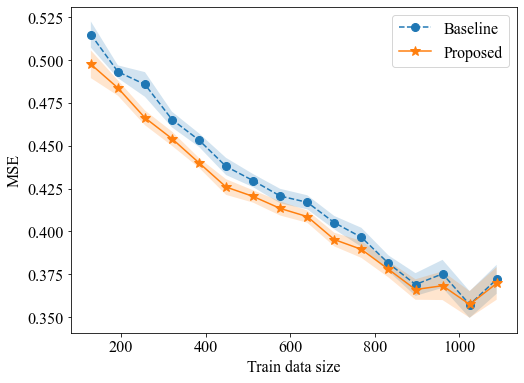

# white_wine

<Figure size 432x288 with 0 Axes>

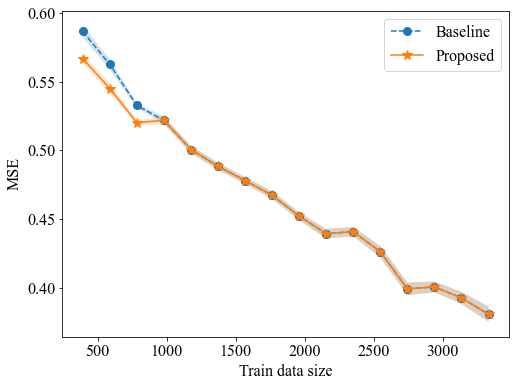

# boston_housing

<Figure size 432x288 with 0 Axes>

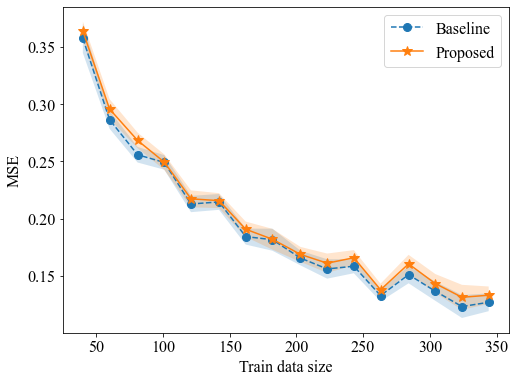

<Figure size 432x288 with 0 Axes>

In [7]:
from itertools import cycle

METHOD_LABELS = {
    'base_xgb': 'Baseline',
    'proposed': 'Proposed'
}

XLABEL = 'Train data size'
YLABEL = 'MSE'

plt.rc('font', **{
    'family': 'Times New Roman',
    'weight' : 'normal',
    'size'   : 16})

monochrome = False

for data_name, run in run_switch.items():
    if not run:
        continue
    printmd(f'# {data_name}')
    _records = records[data_name]

    fig, ax = plt.subplots(figsize=(8,6))
    if monochrome:
        colors = cycle(['k'])
    else:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    linestyles = cycle(['--', '-', '-.', ':'])
    markers = cycle(['o', '*', '^', 's', 'X'])

    plot_df = (_records
     .groupby(['method', 'data', 'train_size'])
     .ply_select(average = X.XGB_MSE.mean(), err_min = X.XGB_MSE.mean()-X.XGB_MSE.sem(ddof=0), err_max = X.XGB_MSE.mean()+X.XGB_MSE.sem(ddof=0))
     .reset_index()
    )

    for ((_method, _data), _df), color, linestyle, marker in zip(plot_df.groupby(['method', 'data']), colors, linestyles, markers):
        kind = 'line'
        ax = plt.gca()
        markersize = 8 if marker not in ['*'] else 10
        _df.plot('train_size', 'average', kind=kind, ax=ax, label=METHOD_LABELS[_method],
                 c=color, marker=marker, linestyle=linestyle, markersize=markersize)
        ax.fill_between(_df['train_size'], _df['err_min'], _df['err_max'], alpha=0.2, facecolor=color)
        plt.xlabel(XLABEL)
        plt.ylabel(YLABEL)
    plt.legend()

    plt.savefig(FIG_OUT_DIR / f'{data_name}{"_mono" if monochrome else ""}.pdf')
    plt.show()
    plt.clf()

# sachs

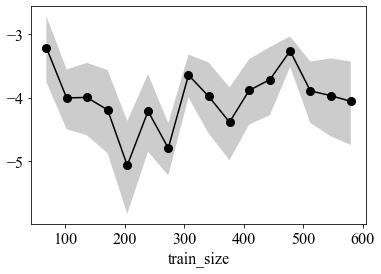

# gss

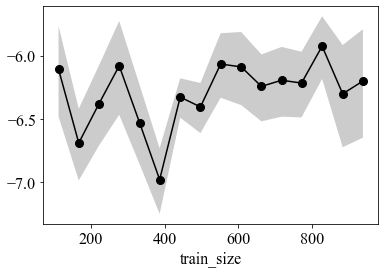

# auto_mpg

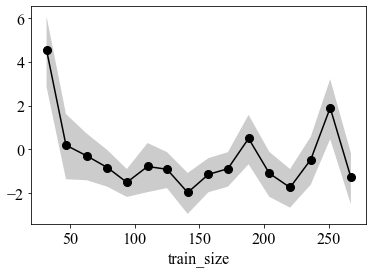

# red_wine

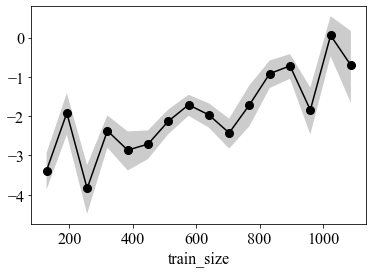

# white_wine

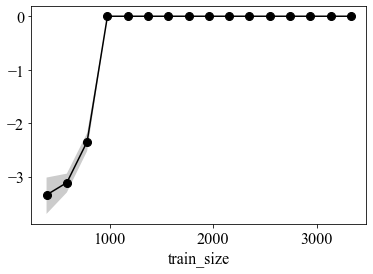

# boston_housing

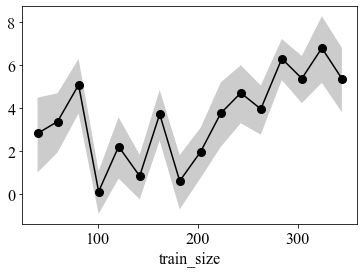

<Figure size 432x288 with 0 Axes>

In [8]:
metric = 'XGB_MSE'
BASELINE_NAME = 'base_xgb'
#TITLE = 'Average relative improvement $\\left(\\frac{aug - orig}{orig} \\times 100\\right)$ %'
TITLE = ''

for data_name, run in run_switch.items():
    if not run:
        continue
    printmd(f'# {data_name}')
    _records = records[data_name]

    all_methods = list(_records.method.unique())

    for method in (set(all_methods)-set([BASELINE_NAME])):
        methods = [BASELINE_NAME, method]
        color = 'k'
        _df = (_records.ply_where(X.method.isin(methods)).sort_values('method').pivot_table(index=['train_size', 'data_run_id'], columns='method_name', values=[metric])
         .pct_change(axis=1).iloc[:, -1].mul(100) # Compute change in %
         .unstack()
        )
        ax = plt.gca()
        _df['err_min'] = _df.mean(axis=1) - _df.sem(axis=1, ddof=0)
        _df['err_max'] = _df.mean(axis=1) + _df.sem(axis=1, ddof=0)
        _df.mean(axis=1).plot(title=TITLE, ax=ax, marker='o', color=color, markersize=8)
        ax.fill_between(_df.index, _df['err_min'], _df['err_max'], alpha=0.2, facecolor=color)

        plt.savefig(FIG_OUT_DIR / f'relative_improvement_{data_name}_{method}.pdf')
        plt.show()
        plt.clf()